In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import albumentations as A
from torch.utils.data import Dataset as TorchDataset
from torch.utils.data import DataLoader
import transformers
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, SegformerConfig
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
import segmentation_models_pytorch as smp
from torch.cuda.amp import autocast, GradScaler
import cv2
from torchvision import transforms
from torch.optim.lr_scheduler import PolynomialLR, ReduceLROnPlateau, MultiStepLR
import torch.nn.functional as F
import tensorflow as tf
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image as grad_preprocess
from pytorch_grad_cam import GradCAM
import logging
from functools import partial
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.11 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations


In [2]:
root_dir = "data"
print(torch.cuda.is_available())  
print(torch.cuda.device_count())  
print(torch.cuda.get_device_name(0)) 
print(torch.cuda.get_device_name(1)) 
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(0)
print(f"Using device: {device}")

True
2
NVIDIA GeForce RTX 4060 Ti
NVIDIA GeForce RTX 3060 Ti
Using device: cuda


In [3]:
class SemanticSegmentationDataset(TorchDataset):
    """
    Data generator for Cityscapes dataset, used for training models.
    """
    def __init__(
        self,
        root_dir,
        image_processor=None,
        target_size=None,
        data_cat="train",
        data_augmentation=False,
        preprocessing_fn=None,
        compute_class_weight=False
    ):
        "Initialization"
        self.target_size = target_size
        self.image_processor = image_processor

        self.img_root = os.path.join(root_dir, f"P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/{data_cat}")
        self.label_root = os.path.join(root_dir, f"P8_Cityscapes_gtFine_trainvaltest/gtFine/{data_cat}")

        # Create full paths for images and labels
        cities = os.listdir(self.img_root)
        self.list_IDs = []  # List of image paths
        self.labels = {}  # Dictionary to store labels against image paths
        self.id2label = {}
        self.label2id = {}

        for city in cities:
            img_dir = os.path.join(self.img_root, city)
            label_dir = os.path.join(self.label_root, city)

            img_names = sorted([name for name in os.listdir(img_dir) if "_leftImg8bit.png" in name])
            label_names = sorted([name.replace("_leftImg8bit.png", "_gtFine_labelIds.png") for name in img_names])

            self.list_IDs.extend([os.path.join(img_dir, name) for name in img_names])
            for i, name in enumerate(img_names):
                self.labels[os.path.join(img_dir, name)] = os.path.join(label_dir, label_names[i])

        assert len(self.list_IDs) == len(self.labels)
        
        with Image.open(self.list_IDs[0]) as img:
            self.original_size = img.size  # (width, height)
        
        if self.target_size is None:
            self.target_size = self.original_size
        
        print(f"Original image size: {self.original_size}")
        print(f"Target image size: {self.target_size}")

        self.categories = {
            "void": [0, 1, 2, 3, 4, 5, 6],
            "flat": [7, 8, 9, 10],
            "construction": [11, 12, 13, 14, 15, 16],
            "object": [17, 18, 19, 20],
            "nature": [21, 22],
            "sky": [23],
            "human": [24, 25],
            "vehicle": [26, 27, 28, 29, 30, 31, 32, 33, -1],
        }
        
        for i, (category, _) in enumerate(self.categories.items()):
            self.id2label[i] = category
            self.label2id[category] = i 

        self.data_augmentation = data_augmentation
        if self.data_augmentation:
            self.augmentor = A.Compose([
            A.OneOf([
                A.HorizontalFlip(p=1),
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),
            ], p=0.5),
            A.OneOf([
                A.CLAHE(clip_limit=2, p=1),
                A.RandomBrightnessContrast(brightness_limit=(-0.1 , 0.2), contrast_limit=(-0.1 ,0.2), brightness_by_max=False, p=1),
            ], p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=1),
                A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1)
            ], p=0.3),
            A.OneOf([
                A.MotionBlur(blur_limit=3, p=1),
                A.MedianBlur(blur_limit=3, p=1),
                A.Blur(blur_limit=3, p=1),
            ], p=0.3),
            A.OneOf([
                A.GaussNoise(var_limit=10, per_channel=True, p=1),
                A.ISONoise(color_shift=(0.01, 0.03), intensity=(0.1, 0.2), p=1),
            ], p=0.5),
            A.OneOf([
                A.OpticalDistortion(distort_limit=(-0.02, 0.02), shift_limit=(-0.02, 0.02), p=1),
                A.GridDistortion(num_steps=3 ,distort_limit=(-0.02, 0.02), p=1)
            ], p=0.3),
            A.OneOf([
                A.RandomFog(fog_coef_lower=0.2, fog_coef_upper=0.5, p=1),
                A.RandomSunFlare(num_flare_circles_lower=2, num_flare_circles_upper=5, src_radius=200, p=1)
            ], p=0.2)
        ], 
        additional_targets={'mask': 'mask'})
        self.preprocessing_fn = preprocessing_fn
        self.compute_class_weight = compute_class_weight
        if self.compute_class_weight:
            self.class_weights = self.compute_class_weights()
        else:
            self.class_weights = None
            
    def __len__(self):
        "Denotes the number of samples in the dataset"
        return len(self.list_IDs)

    def __getitem__(self, index):
        "Generate one sample of data"
        if isinstance(index, list):
            index = index[0]
        ID = self.list_IDs[index]
        X, y = self.__data_generation(ID)
        
        if self.image_processor:
            #Preparation SegFormer
            encoded_inputs = self.image_processor(X, y, return_tensors="pt")
            
            for k,v in encoded_inputs.items():
                encoded_inputs[k].squeeze_() 

            return encoded_inputs
        if self.preprocessing_fn:
            #Preparation FPN
            image = np.array(X).astype(np.float32)
            image = self.preprocessing_fn(image)
            image = np.transpose(image, (2, 0, 1))
            mask = y.astype(np.int64)
            return torch.from_numpy(image).float(), torch.from_numpy(mask).long()
        else:
            return X, y


    def __data_generation(self, ID):
        img = Image.open(ID)
        label_img = Image.open(self.labels[ID])
        
        if img.size != self.target_size:
            img = img.resize(self.target_size, Image.BILINEAR)
            label_img = label_img.resize(self.target_size, Image.NEAREST) 
            
        X = np.array(img).astype(np.float32)
        label = np.array(label_img)
        
        y = np.zeros((self.target_size[1], self.target_size[0]), dtype=np.int64)
        for k, (cat_name, cat_ids) in enumerate(self.categories.items()):
            for cat_id in cat_ids:
                y[label == cat_id] = k
        
        if self.data_augmentation:
            augmented = self.augmentor(
                image=X.astype(np.uint8), mask=y
            )
            img = Image.fromarray(augmented["image"].astype(np.uint8))
            label_img = Image.fromarray(augmented["mask"].astype(np.uint8))
            return np.array(img).astype(np.float32), np.array(label_img)
        
        return X, y
        
    def compute_class_weights(self):
        "Computes the weights for each class based on the training data and normalize"
        pixel_counts = np.zeros(len(self.categories))
        total_pixels = 0

        # We loop through the data as you do in your __data_generation function
        for ID in self.list_IDs:
            label_img = Image.open(self.labels[ID]).resize(
                self.target_size, resample=Image.NEAREST
            )
            label = np.array(label_img)

            for k, (cat_name, cat_ids) in enumerate(self.categories.items()):
                for cat_id in cat_ids:
                    pixel_counts[k] += np.sum(label == cat_id)
            total_pixels += label.size  # Total number of pixels in the image

        class_weights = total_pixels / (len(self.categories) * pixel_counts)
        class_weights = class_weights / np.sum(class_weights)

        return class_weights    


In [4]:
def iou_per_class(y_true, y_pred, num_classes):
    iou_scores = []
    
    for class_id in range(num_classes):
        # Créer des masques binaires pour la classe actuelle
        true_mask = (y_true == class_id)
        pred_mask = (y_pred == class_id)
        
        # Calculer l'intersection et l'union
        intersection = torch.logical_and(true_mask, pred_mask).sum()
        union = torch.logical_or(true_mask, pred_mask).sum()
        
        # Calculer l'IOU pour cette classe
        iou = (intersection / union).item() if union > 0 else 0
        iou_scores.append(iou)
    
    return iou_scores

def dice_coef_loss(predictions, ground_truths, num_classes=8, dims=(2, 3), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    # [B,H,W] -> [B,H,W,C] ->[B,C,H,W]
    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes).permute(0, 3, 1, 2)
    
    # Softmax normalization of predictions
    prediction_norm = F.softmax(predictions, dim=1)
 
    # Intersection and summation
    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)
 
    # Dice coefficient
    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()
 
    # Cross-entropy loss
    CE = F.cross_entropy(predictions, ground_truths)
 
    # Combined loss
    return (1.0 - dice_mean) + CE

# FPN (modèle baseline)

In [277]:
encoder = "resnet101" #44.5M de paramètres
encoder_weights = "imagenet"
preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

train_dataset = SemanticSegmentationDataset(
    root_dir=root_dir,
    image_processor=None,  
    target_size=(1024, 512),
    data_cat="train",
    data_augmentation=True,
    preprocessing_fn=preprocessing_fn
)
valid_dataset = SemanticSegmentationDataset(
    root_dir=root_dir,
    image_processor=None,
    target_size=(1024, 512),
    data_cat="val",
    data_augmentation=False,
    preprocessing_fn=preprocessing_fn
)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=12, shuffle=False)
print(f'Nombre de batchs: {len(train_loader)}')
for batch in train_loader:
    data, target = batch
    print("Shape of data:", data.shape)
    print("Shape of target:", target.shape)
    break 

Original image size: (2048, 1024)
Target image size: (1024, 512)
Original image size: (2048, 1024)
Target image size: (1024, 512)
Nombre de batchs: 248
Shape of data: torch.Size([12, 3, 512, 1024])
Shape of target: torch.Size([12, 512, 1024])


In [7]:
activation = "softmax2d"
device = torch.device('cuda:0') 
print(f"Using GPU: {torch.cuda.get_device_name(0)}")

model = smp.FPN(
    encoder_name=encoder,
    encoder_weights=encoder_weights,
    in_channels=3,
    classes=len(train_dataset.categories),
    activation=activation
)

# criterion = smp.losses.DiceLoss('multiclass')
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006) # même LR que pour SegFormer
model.to(device)
num_epochs = 30
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-4) 
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scheduler = MultiStepLR(optimizer, milestones=[num_epochs // 3], gamma=0.1)
scaler = GradScaler()
writer = SummaryWriter(f'runs/fpn_{encoder}')


Using GPU: NVIDIA GeForce RTX 4060 Ti


In [8]:
patience = 3
patience_counter = 0
best_val_iou = 0
best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_iou = 0
    train_accuracy = 0
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (data, target) in enumerate(train_iterator):
        data, target = data.float().to(device), target.to(device)
        optimizer.zero_grad()
        with autocast():
            output = model(data)
            loss = loss = dice_coef_loss(output, target)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            train_loss += loss.item()
            output = torch.argmax(output, dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes=len(train_dataset.categories))
            train_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
        train_iterator.set_postfix({
            'batch_loss': loss.item(), 
            'gpu_mem_reserved': f'{torch.cuda.memory_reserved(device) / 1024 ** 2} Mo'
        })
    
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)
    train_accuracy /= len(train_loader)
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('IoU/train', train_iou, epoch)  
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    
    # Validation
    model.eval()
    val_loss = 0
    val_iou = 0
    val_accuracy = 0
    val_iou_per_class = torch.zeros(len(train_dataset.categories))
    with torch.no_grad():
        for data, target in tqdm(valid_loader, desc="Validation"):
            data, target = data.float().to(device), target.to(device)
            with autocast():
                output = model(data)
                loss = loss = dice_coef_loss(output, target)
            val_loss += loss.item()
            output = torch.argmax(output, dim=1)  
            tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes=len(train_dataset.categories))
            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            iou_scores = iou_per_class(target, output, len(train_dataset.categories))
            val_iou_per_class += torch.tensor(iou_scores)
            
    val_loss /= len(valid_loader)
    val_iou /= len(valid_loader)
    val_accuracy /= len(valid_loader)
    val_iou_per_class /= len(valid_loader)
    
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('IoU/validation', val_iou, epoch)  
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch)
    val_iou_per_class_dict = {train_dataset.id2label[i]: float(iou) for i, iou in enumerate(val_iou_per_class)}
    writer.add_scalars('IoU_per_class', val_iou_per_class_dict, epoch) 
    
    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean Accuracy: {train_accuracy}, Val Mean Accuracy: {val_accuracy}")
    print(f"Train Mean IoU: {train_iou}, Val Mean IoU: {val_iou}")
    
    if (val_loss < best_val_loss) | (val_iou > best_val_iou):
        best_val_loss = val_loss
        best_val_iou = val_iou
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f'runs/fpn_{encoder}/best_model.pt')
        print(f"New best model saved with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break
    torch.cuda.empty_cache()
    
    scheduler.step(val_iou)

writer.close()

print("\nRécapitulatif des meilleures performances:")
print(f"Meilleure perte de validation: {best_val_loss:.4f}")
print(f"Meilleur IoU de validation: {best_val_iou:.4f}")
sorted_iou = sorted(val_iou_per_class_dict.items(), key=lambda x: x[1], reverse=True)
print("Validation IOU par catégorie :")
for category_name, iou_value in sorted_iou:
    print(f"  {category_name}: {iou_value:.2f}")
# model.load_state_dict(torch.load(f"runs/fpn_{encoder}/best_model.pt"))
# print("Best model loaded")

Validation: 100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Train Loss: 2.34, Val Loss: 2.25
Train Mean Accuracy: 0.9454766511917114, Val Mean Accuracy: 0.9619635343551636
Train Mean IoU: 0.42970767617225647, Val Mean IoU: 0.5274305939674377
New best model saved with validation loss: 2.2538


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.31s/it]


Train Loss: 2.27, Val Loss: 2.23
Train Mean Accuracy: 0.9607904553413391, Val Mean Accuracy: 0.966759979724884
Train Mean IoU: 0.5198445320129395, Val Mean IoU: 0.5625219941139221
New best model saved with validation loss: 2.2314


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.31s/it]


Train Loss: 2.25, Val Loss: 2.23
Train Mean Accuracy: 0.9645952582359314, Val Mean Accuracy: 0.9680618047714233
Train Mean IoU: 0.5402976274490356, Val Mean IoU: 0.5665318369865417
New best model saved with validation loss: 2.2255


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.31s/it]


Train Loss: 2.24, Val Loss: 2.22
Train Mean Accuracy: 0.9666184782981873, Val Mean Accuracy: 0.9693625569343567
Train Mean IoU: 0.5875646471977234, Val Mean IoU: 0.6238543391227722
New best model saved with validation loss: 2.2181


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.24, Val Loss: 2.21
Train Mean Accuracy: 0.9682179093360901, Val Mean Accuracy: 0.9717385172843933
Train Mean IoU: 0.6101871132850647, Val Mean IoU: 0.6426242589950562
New best model saved with validation loss: 2.2068


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.23, Val Loss: 2.21
Train Mean Accuracy: 0.9695284962654114, Val Mean Accuracy: 0.9720698595046997
Train Mean IoU: 0.620602548122406, Val Mean IoU: 0.6474904417991638
New best model saved with validation loss: 2.2056


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.23, Val Loss: 2.21
Train Mean Accuracy: 0.9699193239212036, Val Mean Accuracy: 0.9716511964797974
Train Mean IoU: 0.6246694326400757, Val Mean IoU: 0.645930826663971
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.23, Val Loss: 2.20
Train Mean Accuracy: 0.9706951379776001, Val Mean Accuracy: 0.9719225764274597
Train Mean IoU: 0.6362196207046509, Val Mean IoU: 0.6642653346061707
New best model saved with validation loss: 2.2049


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.22, Val Loss: 2.19
Train Mean Accuracy: 0.9709922671318054, Val Mean Accuracy: 0.974456787109375
Train Mean IoU: 0.6578885316848755, Val Mean IoU: 0.7060231566429138
New best model saved with validation loss: 2.1930


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.22, Val Loss: 2.19
Train Mean Accuracy: 0.9723544716835022, Val Mean Accuracy: 0.974805474281311
Train Mean IoU: 0.6751319766044617, Val Mean IoU: 0.7078991532325745
New best model saved with validation loss: 2.1916


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.21, Val Loss: 2.19
Train Mean Accuracy: 0.9728522896766663, Val Mean Accuracy: 0.9751309156417847
Train Mean IoU: 0.6787809729576111, Val Mean IoU: 0.7160599827766418
New best model saved with validation loss: 2.1899


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.21, Val Loss: 2.19
Train Mean Accuracy: 0.9732659459114075, Val Mean Accuracy: 0.9741654992103577
Train Mean IoU: 0.6834589838981628, Val Mean IoU: 0.712222695350647
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.21, Val Loss: 2.28
Train Mean Accuracy: 0.9730366468429565, Val Mean Accuracy: 0.9554800987243652
Train Mean IoU: 0.683883786201477, Val Mean IoU: 0.6163801550865173
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.21, Val Loss: 2.19
Train Mean Accuracy: 0.9735527038574219, Val Mean Accuracy: 0.9751870036125183
Train Mean IoU: 0.6895006895065308, Val Mean IoU: 0.7171343564987183
New best model saved with validation loss: 2.1889


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.21, Val Loss: 2.19
Train Mean Accuracy: 0.9724265933036804, Val Mean Accuracy: 0.9746079444885254
Train Mean IoU: 0.6820652484893799, Val Mean IoU: 0.7141140699386597
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.21, Val Loss: 2.22
Train Mean Accuracy: 0.9744564890861511, Val Mean Accuracy: 0.9681229591369629
Train Mean IoU: 0.6976596117019653, Val Mean IoU: 0.6904399394989014
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.21, Val Loss: 2.19
Train Mean Accuracy: 0.9736506342887878, Val Mean Accuracy: 0.9759573340415955
Train Mean IoU: 0.6940782070159912, Val Mean IoU: 0.7309121489524841
New best model saved with validation loss: 2.1856


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.18
Train Mean Accuracy: 0.9744027853012085, Val Mean Accuracy: 0.9762341380119324
Train Mean IoU: 0.6998598575592041, Val Mean IoU: 0.7334350943565369
New best model saved with validation loss: 2.1839


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.18
Train Mean Accuracy: 0.9748170375823975, Val Mean Accuracy: 0.976827085018158
Train Mean IoU: 0.7009245753288269, Val Mean IoU: 0.7353722453117371
New best model saved with validation loss: 2.1813


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.18
Train Mean Accuracy: 0.9751293659210205, Val Mean Accuracy: 0.9770721197128296
Train Mean IoU: 0.7055617570877075, Val Mean IoU: 0.7388972043991089
New best model saved with validation loss: 2.1802


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.19
Train Mean Accuracy: 0.9749165177345276, Val Mean Accuracy: 0.9759191870689392
Train Mean IoU: 0.7034244537353516, Val Mean IoU: 0.7306555509567261
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.20, Val Loss: 2.18
Train Mean Accuracy: 0.9750577807426453, Val Mean Accuracy: 0.9767240881919861
Train Mean IoU: 0.7065345048904419, Val Mean IoU: 0.7340916395187378
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.17
Train Mean Accuracy: 0.9755446910858154, Val Mean Accuracy: 0.9788751006126404
Train Mean IoU: 0.7084652781486511, Val Mean IoU: 0.754424512386322
New best model saved with validation loss: 2.1715


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.20, Val Loss: 2.17
Train Mean Accuracy: 0.9765177965164185, Val Mean Accuracy: 0.979726254940033
Train Mean IoU: 0.7187482118606567, Val Mean IoU: 0.760286808013916
New best model saved with validation loss: 2.1676


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.17
Train Mean Accuracy: 0.9761393666267395, Val Mean Accuracy: 0.9794533252716064
Train Mean IoU: 0.7169763445854187, Val Mean IoU: 0.7544285655021667
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.20, Val Loss: 2.17
Train Mean Accuracy: 0.9758022427558899, Val Mean Accuracy: 0.9790049195289612
Train Mean IoU: 0.7170513272285461, Val Mean IoU: 0.756837010383606
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.19, Val Loss: 2.17
Train Mean Accuracy: 0.976798415184021, Val Mean Accuracy: 0.9795069098472595
Train Mean IoU: 0.7232275605201721, Val Mean IoU: 0.7655039429664612
New best model saved with validation loss: 2.1684


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.20, Val Loss: 2.22
Train Mean Accuracy: 0.9762858152389526, Val Mean Accuracy: 0.96869295835495
Train Mean IoU: 0.7194743752479553, Val Mean IoU: 0.7027288675308228
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.30s/it]


Train Loss: 2.20, Val Loss: 2.17
Train Mean Accuracy: 0.9765275716781616, Val Mean Accuracy: 0.9793006181716919
Train Mean IoU: 0.722025454044342, Val Mean IoU: 0.7590004801750183
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 42/42 [00:54<00:00,  1.29s/it]


Train Loss: 2.19, Val Loss: 2.17
Train Mean Accuracy: 0.9768319725990295, Val Mean Accuracy: 0.9799754023551941
Train Mean IoU: 0.7244361042976379, Val Mean IoU: 0.7666453123092651
New best model saved with validation loss: 2.1661

Récapitulatif des meilleures performances:
Meilleure perte de validation: 2.1661
Meilleur IoU de validation: 0.7666
Validation IOU par catégorie :
  flat: 0.93
  sky: 0.88
  nature: 0.86
  vehicle: 0.86
  construction: 0.83
  void: 0.72
  human: 0.60
  object: 0.46


Traitement de l'image : data_sample/images\bremen_000032_000019_leftImg8bit.png
Prédiction enregistrée : data_sample/resnet101_mask\bremen_000032_000019_leftImg8bit.png
Fichier créé avec succès : data_sample/resnet101_mask\bremen_000032_000019_leftImg8bit.png
Taille du fichier : 29139 bytes
Traitement de l'image : data_sample/images\bremen_000134_000019_leftImg8bit.png
Prédiction enregistrée : data_sample/resnet101_mask\bremen_000134_000019_leftImg8bit.png
Fichier créé avec succès : data_sample/resnet101_mask\bremen_000134_000019_leftImg8bit.png
Taille du fichier : 30657 bytes
Traitement de l'image : data_sample/images\bremen_000142_000019_leftImg8bit.png
Prédiction enregistrée : data_sample/resnet101_mask\bremen_000142_000019_leftImg8bit.png
Fichier créé avec succès : data_sample/resnet101_mask\bremen_000142_000019_leftImg8bit.png
Taille du fichier : 12161 bytes
Traitement de l'image : data_sample/images\cologne_000015_000019_leftImg8bit.png
Prédiction enregistrée : data_sample/resnet

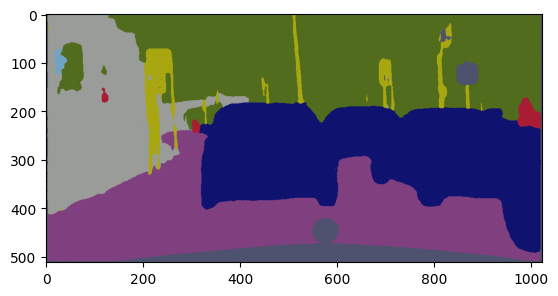

In [15]:
# model.load_state_dict(torch.load(f"runs/fpn_{encoder}/best_model.pt"))
# print("Best model loaded")

def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [78,82,110]
    colormap[1] = [128,64,128]
    colormap[2] = [154,156,153]
    colormap[3] = [168,167,18]
    colormap[4] = [80,108,28]
    colormap[5] = [112,164,196]
    colormap[6] = [168,28,52]
    colormap[7] = [16,18,112]
    return colormap


def preprocess_image(image_path, preprocessing_fn):
    # Chargement de l'image
    img = Image.open(image_path).convert('RGB')
    img = img.resize((1024,512))
    
    # Conversion en array numpy
    img_array = np.array(img).astype(np.float32)
    
    # Application de la fonction de prétraitement (qui pourrait inclure la normalisation)
    if preprocessing_fn:
        img_array = preprocessing_fn(img_array)
    
    # Transposition des canaux pour PyTorch (C, H, W)
    img_array = np.transpose(img_array, (2, 0, 1))
    
    # Conversion en tenseur PyTorch
    img_tensor = torch.from_numpy(img_array).float()
    
    return img_tensor

def predict(image_path):
    model.eval()
    with torch.no_grad():
        # Prétraitement de l'image
        image = preprocess_image(image_path, preprocessing_fn)
        image = image.unsqueeze(0).to(device)  # Ajout de la dimension de batch
        output = model(image)
        pred_mask = torch.argmax(output, dim=1)
        return pred_mask.squeeze().cpu().numpy()

def predict_and_save(image_path, output_dir):
    # Prédiction
    prediction_classes = predict(image_path)
    
    # Application de la colormap
    colormap = create_cityscapes_label_colormap()
    colored_prediction = colormap[prediction_classes]
    plt.imshow(colored_prediction)
    
    # Enregistrement de la prédiction colorée
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    
    try:
        cv2.imwrite(output_path, cv2.cvtColor(colored_prediction, cv2.COLOR_RGB2BGR))
        print(f"Prédiction enregistrée : {output_path}")
    except Exception as e:
        print(f"Erreur lors de l'enregistrement de {output_path}: {str(e)}")

    # Vérification supplémentaire
    if os.path.exists(output_path):
        print(f"Fichier créé avec succès : {output_path}")
        print(f"Taille du fichier : {os.path.getsize(output_path)} bytes")
    else:
        print(f"Le fichier n'a pas été créé : {output_path}")

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

# Dossiers d'entrée et de sortie
input_dir = "data_sample/images"
output_dir = f"data_sample/{encoder}_mask"

# Assurez-vous que le dossier de sortie existe
os.makedirs(output_dir, exist_ok=True)

# Traitement des images
for image_name in os.listdir(input_dir):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(input_dir, image_name)
        print(f"Traitement de l'image : {image_path}")
        predict_and_save(image_path, output_dir)
    else:
        print(f"Fichier ignoré : {image_name}")

print("Traitement terminé.")

torch.Size([3, 512, 1024])


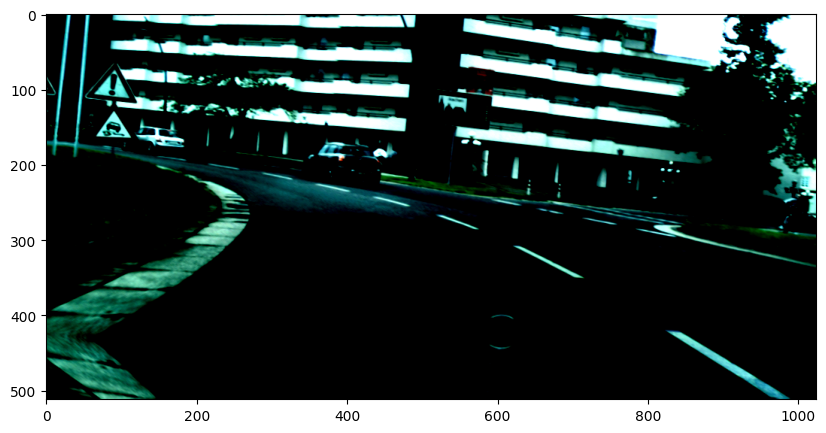

In [339]:
# sample = train_dataset.__getitem__(0)
# print(sample[0].shape)
# img_array = sample[0].numpy()
# img_array = img_array.transpose(1, 2, 0)

# # if img_array.max() > 1.0:
# #     img_array = img_array / 255.0
    

# plt.figure(figsize=(10, 5))  # Ajuster la taille de la figure si nécessaire
# plt.imshow(img_array)
# plt.show()

##### Interpretabilité du modèle

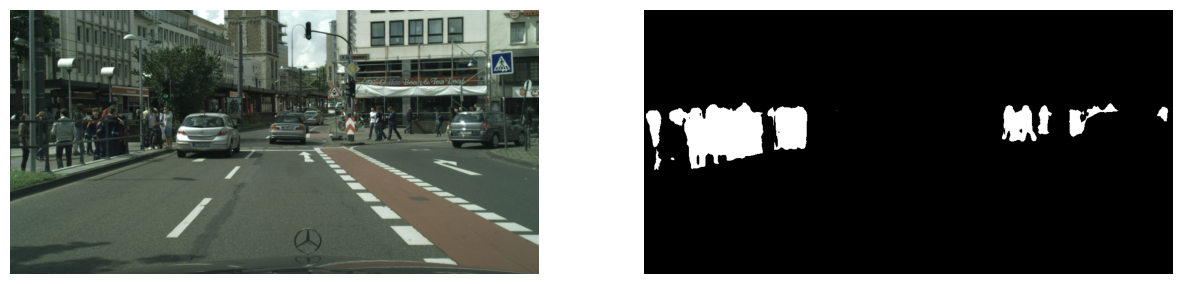

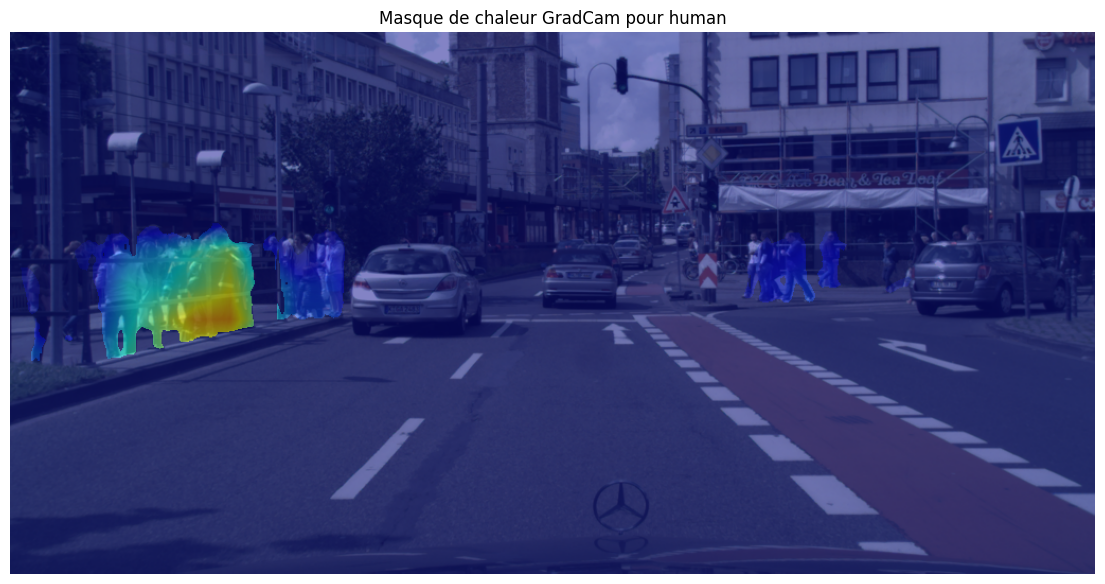

In [333]:
image_url = "data_sample/images/cologne_000015_000019_leftImg8bit.png"
rgb_img = Image.open(image_url).resize((1024, 512))
rgb_img = np.float32(rgb_img) / 255

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
            
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

def explain_model(model, rgb_img, train_dataset, device, label, segformer=False):
    input_tensor = grad_preprocess(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.2])
    input_tensor = input_tensor.to(device) 
    print()
    with torch.no_grad():
        output = model(input_tensor)
        if segformer:
            output = nn.functional.interpolate(output.logits, 
                                                            size=input_tensor.shape[-2:], 
                                                            mode="bilinear", 
                                                            align_corners=False)
    
    # Post-traitement
    normalized_masks = torch.nn.functional.softmax(output, dim=1).cpu()
    category = train_dataset.label2id[label]
    mask = normalized_masks[0].argmax(dim=0).numpy()
    mask_uint8 = 255 * np.uint8(mask == category)
    mask_float = np.float32(mask == category)
    mask_colored = np.repeat(mask_uint8[:, :, None], 3, axis=-1)

    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(rgb_img)
    plt.subplot(1,2,2)
    plt.imshow(mask_colored)
    plt.axis("off")
    plt.show()
    
    # Définition des couches cibles pour Grad-CAM
    target_layers = [model.encoder.layer4]
    targets = [SemanticSegmentationTarget(category, mask_float)]
    threshold = 0.05 #Seuil de 5% de sureté

    # Utilisation de Grad-CAM pour générer la carte de chaleur
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        thresholded_cam = grayscale_cam.copy()
        thresholded_cam[grayscale_cam < threshold] = 0
        thresholded_cam = thresholded_cam / np.max(thresholded_cam)
        masked_cam = thresholded_cam * mask_float
        cam_image = show_cam_on_image(rgb_img, masked_cam, use_rgb=True)

    plt.figure(figsize=(14,9))
    plt.imshow(Image.fromarray(cam_image))
    plt.title(f"Masque de chaleur GradCam pour {label}")
    plt.axis("Off")

explain_model(model, rgb_img, train_dataset, device, "human")

# SegFormer (modèle avancé)

In [5]:
checkpoint = "nvidia/segformer-b4-finetuned-cityscapes-1024-1024"  #62.6M de paramètres
image_processor = SegformerImageProcessor()

train_dataset = SemanticSegmentationDataset(root_dir=root_dir,  
                                            image_processor=image_processor, 
                                            target_size=(1024, 512),
                                            data_augmentation=True)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, 
                                            image_processor=image_processor,
                                            target_size=(1024, 512),
                                            data_augmentation=False, 
                                            data_cat='val')
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=8)

print(f'Nombre de batchs: {len(train_dataloader)}')
for batch in train_dataloader:
    data = batch["pixel_values"]
    target = batch["labels"]
    print("Shape of data:", data.shape)
    print("Shape of target:", target.shape)
    break

model = SegformerForSemanticSegmentation.from_pretrained(checkpoint, num_labels=len(train_dataset.id2label), id2label=train_dataset.id2label, label2id=train_dataset.label2id, ignore_mismatched_sizes=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=1e-2) 
num_epochs = 20
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scheduler = MultiStepLR(optimizer, milestones=[num_epochs // 2], gamma=0.1)

Original image size: (2048, 1024)
Target image size: (1024, 512)
Original image size: (2048, 1024)
Target image size: (1024, 512)
Nombre de batchs: 372
Shape of data: torch.Size([8, 3, 512, 512])
Shape of target: torch.Size([8, 512, 512])


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([8, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mise en place de dropout 


In [6]:
def set_encoder_dropout(model, dropout_rate):
    dropout_count = 0
    for name, module in model.named_modules():
        if 'segformer.encoder.block' in name and isinstance(module, nn.Dropout):
            module.p = dropout_rate
            dropout_count += 1
    logging.info(f"Set {dropout_count} encoder dropouts to {dropout_rate}")

def set_attention_dropout(model, dropout_rate):
    dropout_count = 0
    for name, module in model.named_modules():
        if 'attention.self.dropout' in name:
            module.p = dropout_rate
            dropout_count += 1
    logging.info(f"Set {dropout_count} attention dropouts to {dropout_rate}")

def set_mlp_dropout(model, dropout_rate):
    dropout_count = 0
    for name, module in model.named_modules():
        if 'mlp.dropout' in name:
            module.p = dropout_rate
            dropout_count += 1
    logging.info(f"Set {dropout_count} MLP dropouts to {dropout_rate}")
    
def set_decode_head_dropout(model, dropout_rate):
    dropout_count = 0
    for name, module in model.named_modules():
        if 'decode_head.dropout' in name:
            module.p = dropout_rate
            dropout_count += 1
    logging.info(f"Set {dropout_count} decoder head dropout to {dropout_rate}")

def set_all_dropouts(model, encoder_rate, attention_rate, mlp_rate, decoder_rate):
    set_encoder_dropout(model, encoder_rate)
    set_attention_dropout(model, attention_rate)
    set_mlp_dropout(model, mlp_rate)
    set_decode_head_dropout(model, decoder_rate)

set_all_dropouts(model, 0.2, 0.3, 0.2, 0.3)

INFO:root:Set 123 encoder dropouts to 0.2
INFO:root:Set 41 attention dropouts to 0.3
INFO:root:Set 41 MLP dropouts to 0.2
INFO:root:Set 1 decoder head dropout to 0.3


Encoder dropouts (123) :
Ces dropouts sont appliqués dans les blocs de l'encodeur du Segformer. Ils aident à réduire le surapprentissage dans la partie qui extrait les caractéristiques de l'image d'entrée.  
Attention dropouts (41) :
Ces dropouts sont spécifiques aux mécanismes d'attention. Ils sont appliqués après les opérations d'attention pour réduire la dépendance excessive à certaines parties de l'entrée.  
MLP dropouts (41) :
Ces dropouts sont appliqués dans les couches MLP (Multi-Layer Perceptron) du modèle. Ils aident à prévenir la co-adaptation des neurones dans ces couches fully connected.  
Decoder head dropout (1) :
Ce dropout est appliqué dans la tête de décodage du Segformer. Il aide à régulariser la partie finale du modèle qui produit la segmentation.  

In [7]:

writer = SummaryWriter(f'runs/{checkpoint}')
scaler = GradScaler()
best_val_iou = 0
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model = model.to(device)
    model.train()
    train_loss = 0
    train_iou = 0
    train_accuracy = 0
    train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for idx, batch in enumerate(train_iterator):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        
        with autocast():
            output = model(pixel_values=pixel_values)
            upsampled_logits = nn.functional.interpolate(output.logits, 
                                                         size=labels.shape[-2:], 
                                                         mode="bilinear", 
                                                         align_corners=False)
            loss = dice_coef_loss(upsampled_logits, labels)
                
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            train_loss += loss.item()
            predicted = upsampled_logits.argmax(dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(predicted, labels, mode='multiclass', num_classes=len(train_dataset.categories))
            train_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            train_iterator.set_postfix({
            'batch_loss': loss.item(), 
            'gpu_mem_reserved': f'{torch.cuda.memory_reserved(device) / 1024 ** 2} Mo'
        })
            
    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('IoU/train',train_iou, epoch)  
    writer.add_scalar('Accuracy/train', train_accuracy, epoch) 

    model.eval()
    val_loss = 0
    val_iou = 0
    val_accuracy = 0
    val_iou_per_class = torch.zeros(len(valid_dataset.categories))
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(valid_dataloader, desc="Validation")):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            
            with autocast():
                output = model(pixel_values=pixel_values)
                upsampled_logits = nn.functional.interpolate(output.logits, 
                                                            size=labels.shape[-2:], 
                                                            mode="bilinear", 
                                                            align_corners=False)
                loss = dice_coef_loss(upsampled_logits, labels)
                
            predicted = upsampled_logits.argmax(dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(predicted, labels, mode='multiclass', num_classes=len(train_dataset.categories))
            val_loss += loss.item()
            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            iou_scores = iou_per_class(labels, predicted, len(train_dataset.categories))
            val_iou_per_class += torch.tensor(iou_scores)

            
    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_accuracy /= len(valid_dataloader)
    val_iou_per_class /= len(valid_dataloader)
    
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('IoU/validation', val_iou, epoch)  
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch) 
    val_iou_per_class_dict = {train_dataset.id2label[i]: float(iou) for i, iou in enumerate(val_iou_per_class)}
    writer.add_scalars('IoU_per_class', val_iou_per_class_dict, epoch) 
    
    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean IoU: {train_iou}, Val Mean IoU: {val_iou}")
    print(f"Train Mean Accuracy: {train_accuracy}, Val Mean Accuracy: {val_accuracy}")
    
    if (val_loss < best_val_loss) | (val_iou > best_val_iou):
        best_val_loss = val_loss
        best_val_iou = val_iou
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"runs/{checkpoint}/best_model.pt")
        print(f"New best model saved with validation loss: {best_val_loss:.2f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break
    
    scheduler.step()
    
writer.close()

# model.load_state_dict(torch.load(f"runs/{checkpoint}/best_model.pt"))
# print("Best model loaded")
print("\nRécapitulatif des meilleures performances:")
print(f"Meilleure perte de validation: {best_val_loss:.4f}")
print(f"Meilleur IoU de validation: {best_val_iou:.4f}")
sorted_iou = sorted(val_iou_per_class_dict.items(), key=lambda x: x[1], reverse=True)
print("Validation IOU par catégorie :")
for category_name, iou_value in sorted_iou:
    print(f"  {category_name}: {iou_value:.2f}")




Epoch 1/20:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/20:   1%|          | 4/372 [00:10<15:44,  2.57s/it, batch_loss=2.28, gpu_mem_reserved=13796.0 Mo]

In [6]:
writer = SummaryWriter(f'runs/{checkpoint}')
scaler = GradScaler()
best_val_iou = 0
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model = model.to(device)
    model.train()
    train_loss = 0
    train_iou = 0
    train_accuracy = 0
    train_iterator = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for idx, batch in enumerate(train_iterator):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        
        with autocast():
            output = model(pixel_values=pixel_values)
            upsampled_logits = nn.functional.interpolate(output.logits, 
                                                         size=labels.shape[-2:], 
                                                         mode="bilinear", 
                                                         align_corners=False)
            loss = dice_coef_loss(upsampled_logits, labels)
                
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        with torch.no_grad():
            train_loss += loss.item()
            predicted = upsampled_logits.argmax(dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(predicted, labels, mode='multiclass', num_classes=len(train_dataset.categories))
            train_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            train_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            train_iterator.set_postfix({
            'batch_loss': loss.item(), 
            'gpu_mem_reserved': f'{torch.cuda.memory_reserved(device) / 1024 ** 2} Mo'
        })
            
    train_loss /= len(train_dataloader)
    train_iou /= len(train_dataloader)
    train_accuracy /= len(train_dataloader)
    
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('IoU/train',train_iou, epoch)  
    writer.add_scalar('Accuracy/train', train_accuracy, epoch) 

    model.eval()
    val_loss = 0
    val_iou = 0
    val_accuracy = 0
    val_iou_per_class = torch.zeros(len(valid_dataset.categories))
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(valid_dataloader, desc="Validation")):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            
            with autocast():
                output = model(pixel_values=pixel_values)
                upsampled_logits = nn.functional.interpolate(output.logits, 
                                                            size=labels.shape[-2:], 
                                                            mode="bilinear", 
                                                            align_corners=False)
                loss = dice_coef_loss(upsampled_logits, labels)
                
            predicted = upsampled_logits.argmax(dim=1)
            tp, fp, fn, tn = smp.metrics.get_stats(predicted, labels, mode='multiclass', num_classes=len(train_dataset.categories))
            val_loss += loss.item()
            val_accuracy += smp.metrics.accuracy(tp, fp, fn, tn, reduction="macro")
            val_iou += smp.metrics.iou_score(tp, fp, fn, tn, reduction="macro")
            iou_scores = iou_per_class(labels, predicted, len(train_dataset.categories))
            val_iou_per_class += torch.tensor(iou_scores)

            
    val_loss /= len(valid_dataloader)
    val_iou /= len(valid_dataloader)
    val_accuracy /= len(valid_dataloader)
    val_iou_per_class /= len(valid_dataloader)
    
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('IoU/validation', val_iou, epoch)  
    writer.add_scalar('Accuracy/validation', val_accuracy, epoch) 
    val_iou_per_class_dict = {train_dataset.id2label[i]: float(iou) for i, iou in enumerate(val_iou_per_class)}
    writer.add_scalars('IoU_per_class', val_iou_per_class_dict, epoch) 
    
    print(f"Train Loss: {train_loss:.2f}, Val Loss: {val_loss:.2f}")
    print(f"Train Mean IoU: {train_iou}, Val Mean IoU: {val_iou}")
    print(f"Train Mean Accuracy: {train_accuracy}, Val Mean Accuracy: {val_accuracy}")
    
    if (val_loss < best_val_loss) | (val_iou > best_val_iou):
        best_val_loss = val_loss
        best_val_iou = val_iou
        patience_counter = 0
        best_model_state = model.state_dict()
        torch.save(best_model_state, f"runs/{checkpoint}/best_model.pt")
        print(f"New best model saved with validation loss: {best_val_loss:.2f}")
    else:
        patience_counter += 1
        print(f"EarlyStopping counter: {patience_counter} out of {patience}")

    if patience_counter >= patience:
        print("Early stopping")
        break
    
    scheduler.step()
    
writer.close()

# model.load_state_dict(torch.load(f"runs/{checkpoint}/best_model.pt"))
# print("Best model loaded")
print("\nRécapitulatif des meilleures performances:")
print(f"Meilleure perte de validation: {best_val_loss:.4f}")
print(f"Meilleur IoU de validation: {best_val_iou:.4f}")
sorted_iou = sorted(val_iou_per_class_dict.items(), key=lambda x: x[1], reverse=True)
print("Validation IOU par catégorie :")
for category_name, iou_value in sorted_iou:
    print(f"  {category_name}: {iou_value:.2f}")


Epoch 1/30:   0%|          | 0/372 [00:00<?, ?it/s]c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Validation: 100%|██████████| 63/63 [01:10<00:00,  1.13s/it]


Train Loss: 0.92, Val Loss: 0.58
Train Mean IoU: 0.6188917756080627, Val Mean IoU: 0.718733012676239
Train Mean Accuracy: 0.9665105938911438, Val Mean Accuracy: 0.9764482975006104
New best model saved with validation loss: 0.58


Validation: 100%|██████████| 63/63 [01:08<00:00,  1.08s/it]


Train Loss: 0.69, Val Loss: 0.53
Train Mean IoU: 0.7000882625579834, Val Mean IoU: 0.7363028526306152
Train Mean Accuracy: 0.9748253226280212, Val Mean Accuracy: 0.9777668118476868
New best model saved with validation loss: 0.53


Validation: 100%|██████████| 63/63 [01:07<00:00,  1.07s/it]


Train Loss: 0.67, Val Loss: 0.52
Train Mean IoU: 0.7067516446113586, Val Mean IoU: 0.7419835925102234
Train Mean Accuracy: 0.9753463268280029, Val Mean Accuracy: 0.9783719182014465
New best model saved with validation loss: 0.52


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.65, Val Loss: 0.50
Train Mean IoU: 0.7159249782562256, Val Mean IoU: 0.7485842108726501
Train Mean Accuracy: 0.9763813018798828, Val Mean Accuracy: 0.9789162874221802
New best model saved with validation loss: 0.50


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.62, Val Loss: 0.51
Train Mean IoU: 0.7243047952651978, Val Mean IoU: 0.7460809946060181
Train Mean Accuracy: 0.9771377444267273, Val Mean Accuracy: 0.978514552116394
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.61, Val Loss: 0.49
Train Mean IoU: 0.7294579148292542, Val Mean IoU: 0.7538158297538757
Train Mean Accuracy: 0.9780858159065247, Val Mean Accuracy: 0.9792678356170654
New best model saved with validation loss: 0.49


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Train Loss: 0.61, Val Loss: 0.48
Train Mean IoU: 0.7294191122055054, Val Mean IoU: 0.7618475556373596
Train Mean Accuracy: 0.9776932001113892, Val Mean Accuracy: 0.9797847867012024
New best model saved with validation loss: 0.48


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.59, Val Loss: 0.49
Train Mean IoU: 0.7373175024986267, Val Mean IoU: 0.7575070261955261
Train Mean Accuracy: 0.9785205721855164, Val Mean Accuracy: 0.9792349338531494
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.59, Val Loss: 0.49
Train Mean IoU: 0.7398766279220581, Val Mean IoU: 0.7646951079368591
Train Mean Accuracy: 0.9786651134490967, Val Mean Accuracy: 0.980301022529602
New best model saved with validation loss: 0.49


Validation: 100%|██████████| 63/63 [01:05<00:00,  1.05s/it]


Train Loss: 0.59, Val Loss: 0.47
Train Mean IoU: 0.739585816860199, Val Mean IoU: 0.7649475336074829
Train Mean Accuracy: 0.9787497520446777, Val Mean Accuracy: 0.9806916117668152
New best model saved with validation loss: 0.47


Validation: 100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Train Loss: 0.55, Val Loss: 0.46
Train Mean IoU: 0.7559526562690735, Val Mean IoU: 0.7728187441825867
Train Mean Accuracy: 0.9808801412582397, Val Mean Accuracy: 0.9807960987091064
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.53, Val Loss: 0.46
Train Mean IoU: 0.7629492282867432, Val Mean IoU: 0.7749398350715637
Train Mean Accuracy: 0.9817317128181458, Val Mean Accuracy: 0.9810017347335815
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it]


Train Loss: 0.52, Val Loss: 0.46
Train Mean IoU: 0.7656925320625305, Val Mean IoU: 0.7758192420005798
Train Mean Accuracy: 0.9818610548973083, Val Mean Accuracy: 0.9810931086540222
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:13<00:00,  1.16s/it]


Train Loss: 0.51, Val Loss: 0.46
Train Mean IoU: 0.7698178887367249, Val Mean IoU: 0.7774330377578735
Train Mean Accuracy: 0.9824908971786499, Val Mean Accuracy: 0.9812074303627014
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:10<00:00,  1.11s/it]


Train Loss: 0.51, Val Loss: 0.46
Train Mean IoU: 0.7691408395767212, Val Mean IoU: 0.7789148092269897
Train Mean Accuracy: 0.982297420501709, Val Mean Accuracy: 0.9813205599784851
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:09<00:00,  1.11s/it]


Train Loss: 0.51, Val Loss: 0.46
Train Mean IoU: 0.7717411518096924, Val Mean IoU: 0.7798432111740112
Train Mean Accuracy: 0.9826947450637817, Val Mean Accuracy: 0.9813214540481567
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.50, Val Loss: 0.46
Train Mean IoU: 0.7754186987876892, Val Mean IoU: 0.7801752090454102
Train Mean Accuracy: 0.9830950498580933, Val Mean Accuracy: 0.9814022779464722
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Train Loss: 0.50, Val Loss: 0.46
Train Mean IoU: 0.7739931344985962, Val Mean IoU: 0.7806434035301208
Train Mean Accuracy: 0.9830976128578186, Val Mean Accuracy: 0.9815642237663269
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Train Loss: 0.50, Val Loss: 0.46
Train Mean IoU: 0.7762313485145569, Val Mean IoU: 0.7816112041473389
Train Mean Accuracy: 0.9830804467201233, Val Mean Accuracy: 0.9816312789916992
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


Train Loss: 0.49, Val Loss: 0.46
Train Mean IoU: 0.7776278257369995, Val Mean IoU: 0.7809719443321228
Train Mean Accuracy: 0.9834722876548767, Val Mean Accuracy: 0.9815186858177185
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Train Loss: 0.49, Val Loss: 0.46
Train Mean IoU: 0.7769831418991089, Val Mean IoU: 0.7818615436553955
Train Mean Accuracy: 0.9833705425262451, Val Mean Accuracy: 0.9818081259727478
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


Train Loss: 0.49, Val Loss: 0.47
Train Mean IoU: 0.7802398800849915, Val Mean IoU: 0.7818452715873718
Train Mean Accuracy: 0.9835763573646545, Val Mean Accuracy: 0.9815443754196167
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


Train Loss: 0.49, Val Loss: 0.48
Train Mean IoU: 0.7782109379768372, Val Mean IoU: 0.7821999192237854
Train Mean Accuracy: 0.983268141746521, Val Mean Accuracy: 0.9814292192459106
New best model saved with validation loss: 0.48


Validation: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


Train Loss: 0.48, Val Loss: 0.46
Train Mean IoU: 0.7801480889320374, Val Mean IoU: 0.7823438048362732
Train Mean Accuracy: 0.9836597442626953, Val Mean Accuracy: 0.9814344048500061
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:07<00:00,  1.06s/it]


Train Loss: 0.49, Val Loss: 0.46
Train Mean IoU: 0.7800998687744141, Val Mean IoU: 0.7839312553405762
Train Mean Accuracy: 0.9836890697479248, Val Mean Accuracy: 0.9816572070121765
New best model saved with validation loss: 0.46


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.48, Val Loss: 0.46
Train Mean IoU: 0.7823643088340759, Val Mean IoU: 0.7829203605651855
Train Mean Accuracy: 0.9837533235549927, Val Mean Accuracy: 0.9817999005317688
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.05s/it]


Train Loss: 0.48, Val Loss: 0.45
Train Mean IoU: 0.7826625108718872, Val Mean IoU: 0.7845103144645691
Train Mean Accuracy: 0.9838858246803284, Val Mean Accuracy: 0.9821999073028564
New best model saved with validation loss: 0.45


Validation: 100%|██████████| 63/63 [01:06<00:00,  1.06s/it]


Train Loss: 0.48, Val Loss: 0.45
Train Mean IoU: 0.7838947772979736, Val Mean IoU: 0.7843155860900879
Train Mean Accuracy: 0.9840883016586304, Val Mean Accuracy: 0.9821732044219971
EarlyStopping counter: 1 out of 3


Validation: 100%|██████████| 63/63 [01:07<00:00,  1.08s/it]


Train Loss: 0.47, Val Loss: 0.47
Train Mean IoU: 0.7863849997520447, Val Mean IoU: 0.7842450141906738
Train Mean Accuracy: 0.9843418598175049, Val Mean Accuracy: 0.9814378619194031
EarlyStopping counter: 2 out of 3


Validation: 100%|██████████| 63/63 [01:10<00:00,  1.11s/it]

Train Loss: 0.48, Val Loss: 0.47
Train Mean IoU: 0.7863967418670654, Val Mean IoU: 0.783699095249176
Train Mean Accuracy: 0.9843315482139587, Val Mean Accuracy: 0.9812615513801575
EarlyStopping counter: 3 out of 3
Early stopping

Récapitulatif des meilleures performances:
Meilleure perte de validation: 0.4489
Meilleur IoU de validation: 0.7845
Validation IOU par catégorie :
  flat: 0.92
  sky: 0.89
  nature: 0.88
  vehicle: 0.88
  construction: 0.86
  void: 0.71
  human: 0.63
  object: 0.50


stop

## Predictions

In [7]:
# model.load_state_dict(torch.load(f"runs/{checkpoint}/best_model.pt"))
# print("Best model loaded")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# model.eval()
valid_dataset = SemanticSegmentationDataset(root_dir='data',image_processor=False, target_size=(1024,512), data_cat='val', data_augmentation=False)
image, labels = valid_dataset.__getitem__(0)

image = Image.fromarray(image.astype(np.uint8))
mask_array = Image.fromarray(labels.astype(np.uint8))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoding = image_processor(image, return_tensors="pt")
pixel_values = encoding.pixel_values.to(device)
outputs = model(pixel_values=pixel_values)
logits = outputs.logits.cpu()
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
)
pred_seg = upsampled_logits.argmax(dim=1)[0]

Original image size: (2048, 1024)
Target image size: (1024, 512)


c:\Users\aurel\Documents\Master\Developpez une preuve de concept\.venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


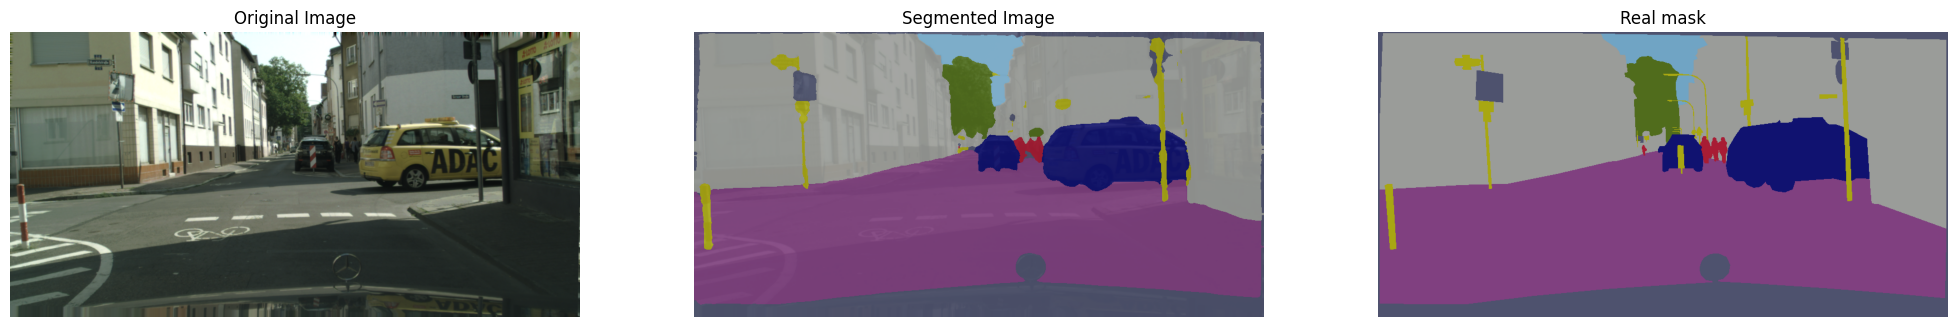

In [8]:
def create_cityscapes_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [78,82,110]
    colormap[1] = [128,64,128]
    colormap[2] = [154,156,153]
    colormap[3] = [168,167,18]
    colormap[4] = [80,108,28]
    colormap[5] = [112,164,196]
    colormap[6] = [168,28,52]
    colormap[7] = [16,18,112]
    return colormap

def apply_colormap(segmentation_map, colormap):
    colored_map = colormap[segmentation_map]
    return colored_map

def blend_images(original_image, colored_segmentation, alpha=0.6):
    blended_image = Image.blend(original_image, colored_segmentation, alpha)
    return blended_image


colored_segmentation = apply_colormap(pred_seg, create_cityscapes_label_colormap())
colored_segmentation_image = Image.fromarray(colored_segmentation.astype(np.uint8))
colored_real_mask = apply_colormap(mask_array, create_cityscapes_label_colormap())
colored_real_mask_image = Image.fromarray(colored_real_mask.astype(np.uint8))

blended_image = blend_images(image, colored_segmentation_image, alpha=0.9)


plt.figure(figsize=(25, 20))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(blended_image)
plt.title("Segmented Image")
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(colored_real_mask)
plt.title("Real mask")
plt.axis('off')
plt.show()

##### Interpretabilité du modèle

In [6]:
model.load_state_dict(torch.load(f"runs/{checkpoint}/best_model.pt"))
print("Best model loaded")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

Best model loaded


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

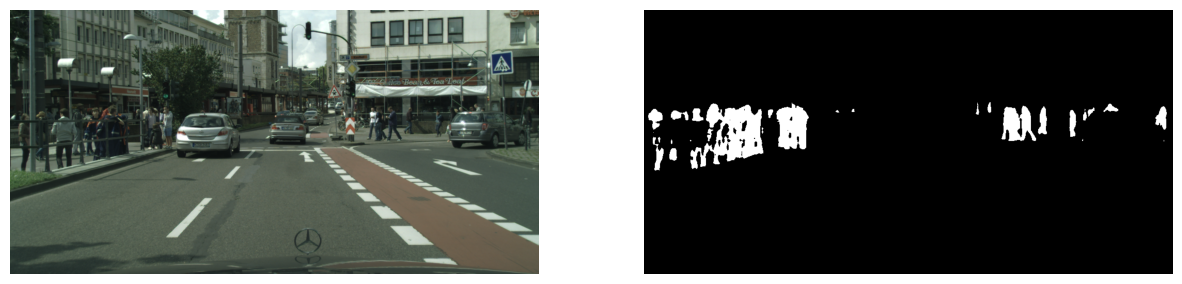

GradCAM output shape: (1, 512, 1024)


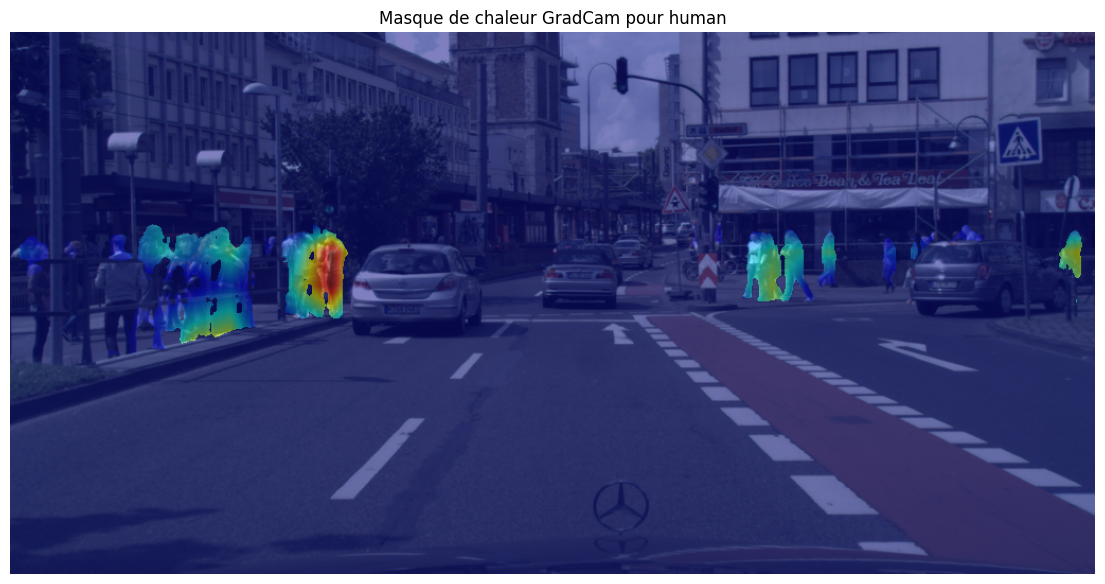

In [9]:
image_url = "data_sample/images/cologne_000015_000019_leftImg8bit.png"
rgb_img = Image.open(image_url).resize((1024, 512))
rgb_img = np.float32(rgb_img) / 255
img_tensor = transforms.ToTensor()(rgb_img)

class SegformerWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        output = self.model(x)
        return output.logits

class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()
    
    def __call__(self, model_output):
        if isinstance(model_output, (dict, transformers.modeling_outputs.SemanticSegmenterOutput)):
            logits = model_output['logits'] if isinstance(model_output, dict) else model_output.logits
        elif isinstance(model_output, torch.Tensor):
            logits = model_output
        else:
            raise ValueError(f"Unexpected model_output type: {type(model_output)}")
        
        if logits.dim() == 4:  # [batch, classes, height, width]
            return (logits[0, self.category, :, :] * self.mask).sum()
        elif logits.dim() == 3:  # [classes, height, width]
            return (logits[self.category, :, :] * self.mask).sum()
        else:
            raise ValueError(f"Unexpected logits shape: {logits.shape}")
    
def segformer_reshape_transform_huggingface(tensor, width, height):
    result = tensor.reshape(tensor.size(0),
                            height,
                            width,
                            tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result


reshape_transform = partial(segformer_reshape_transform_huggingface, #réorganise les dimensions du tenseur pour qu'elles correspondent au format attendu par GradCAM.
                            width=img_tensor.shape[2]//32,
                            height=img_tensor.shape[1]//32)

def explain_model(model, rgb_img, train_dataset, device, label, segformer=True):
    input_tensor = grad_preprocess(rgb_img,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.2])
    input_tensor = input_tensor.to(device)
    wrapped_model = SegformerWrapper(model)
    with torch.no_grad():
        output = wrapped_model(input_tensor)
        upsampled_logits = nn.functional.interpolate(output, 
                                                    size=input_tensor.shape[-2:], 
                                                    mode="bilinear", 
                                                    align_corners=False)
    
    normalized_masks = torch.nn.functional.softmax(upsampled_logits, dim=1).cpu()
    category = train_dataset.label2id[label]
    mask = normalized_masks[0].argmax(dim=0).numpy()
    mask_uint8 = 255 * np.uint8(mask == category)
    mask_float = np.float32(mask == category)
    mask_colored = np.repeat(mask_uint8[:, :, None], 3, axis=-1)

    plt.figure(figsize=(15,10))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.imshow(rgb_img)
    plt.subplot(1,2,2)
    plt.imshow(mask_colored)
    plt.axis("off")
    plt.show()
    
    target_layers = [wrapped_model.model.segformer.encoder.layer_norm[-1]]
    mask_float_resized = cv2.resize(mask_float, (output.shape[3], output.shape[2]))
    targets = [SemanticSegmentationTarget(category, mask_float_resized)]

    cam = GradCAM(model=wrapped_model, target_layers=target_layers,
                  reshape_transform=reshape_transform)
    
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    print(f"GradCAM output shape: {grayscale_cam.shape}")
    
    threshold = 0.05  # Seuil de 5% de sureté
    thresholded_cam = grayscale_cam.copy()
    thresholded_cam[grayscale_cam < threshold] = 0
    thresholded_cam = thresholded_cam / np.max(thresholded_cam)
    
    # Resize the CAM to match the input image size
    resized_cam = cv2.resize(thresholded_cam[0], (input_tensor.shape[3], input_tensor.shape[2]))
    
    masked_cam = resized_cam * mask_float
    cam_image = show_cam_on_image(rgb_img, masked_cam, use_rgb=True)

    plt.figure(figsize=(14,9))
    plt.imshow(cam_image)
    plt.title(f"Masque de chaleur GradCam pour {label}")
    plt.axis("Off")
    plt.show()

# Appel de la fonction
explain_model(model, rgb_img, train_dataset, device, "human", segformer=True)